# Partial Label Learningのノートブック

In [1]:
from matplotlib import pyplot as plt
import polars as pl
import seaborn as sns
import japanize_matplotlib

from common import *

In [2]:
# ハイパーパラメータ
N_COMPONENTS = 50
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [3]:
# データセットの読み込み
X_train, X_val, X_test, y_train, y_val, y_test = load_mnist_pca_train_test_val(
    n_components=N_COMPONENTS, test_size=TEST_SIZE, val_size=VAL_SIZE
)

Files already downloaded
Files already downloaded


In [4]:
# Partial Label Learningの設定にラベルを変更
X_train, y_train = rewrite_label_with_pll_setting(X_train, y_train, positive_rate=0.2)

646
71
5
2
0


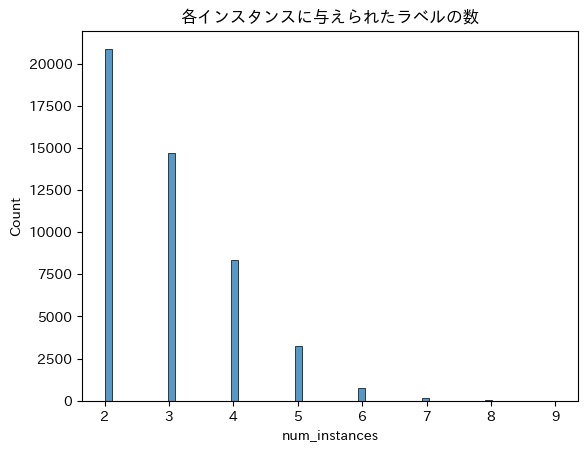

In [5]:
sns.histplot(pl.DataFrame(y_train.sum(-1), schema=["num_instances"]), x="num_instances")
plt.title("各インスタンスに与えられたラベルの数")
plt.show()

In [6]:


def train_lgbm_with_custom_loss(X_train, X_val, y_train, y_val):
    """Train LightGBM with custom loss function."""
    train_data = lgb.Dataset(X_train, label=np.zeros(len(y_train)), free_raw_data=False)
    train_data._partial_labels = y_train
    train_data._pweight = y_train / y_train.sum(axis=-1, keepdims=True)
    valid_data = lgb.Dataset(X_val, label=y_val, free_raw_data=False)
    params = {
        "objective": "custom",
        "metric": "custom",
        "verbose": -1,
        "learning_rate": 0.1,
        "num_boost_round": 200,
        "num_class": 10
    }
    valid_accuracies = []

    def record_accuracies(p: lgb.Booster, train_data: lgb.Dataset, valid_data: lgb.Dataset):
        valid_pred = p.predict(valid_data.data).argmax(-1)
        valid_acc = accuracy_score(valid_data.label, valid_pred)
        valid_accuracies.append(valid_acc)
        print(valid_acc)
    
    gbm = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        fobj=pll_loss_objective,
        feval=multiclass_metric,
        callbacks=[lambda p: record_accuracies(p.model, train_data, valid_data)]
    )
    return gbm, valid_accuracies

In [7]:
gbm, valid_accuracies =train_lgbm_with_custom_loss(X_train, X_val, y_train, y_val)
y_pred = gbm.predict(X_val)
print("Accuracy: {}".format(accuracy_score(y_val, y_pred.argmax(-1))))

/Users/ryoma.kobayashi/gits/techblog_git/wsl_w_lgbm/.venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.7949166666666667
0.82475
0.8288333333333333
0.8333333333333334
0.8394166666666667
0.842
0.8456666666666667
0.8480833333333333
0.8495
0.8504166666666667
0.8530833333333333
0.8574166666666667
0.85975
0.8635
0.8654166666666666
0.8689166666666667
0.8715833333333334
0.874
0.8765
0.8785
0.8811666666666667
0.884
0.88525
0.88875
0.8914166666666666
0.89275
0.8945833333333333
0.89675
0.8983333333333333
0.90125
0.9026666666666666
0.9040833333333333
0.9069166666666667
0.909
0.9094166666666667
0.911
0.9139166666666667
0.9148333333333334
0.9169166666666667
0.918
0.9193333333333333
0.9206666666666666
0.922
0.9235833333333333
0.925
0.9265833333333333
0.9266666666666666
0.92775
0.9285833333333333
0.9295
0.9298333333333333
0.931
0.9321666666666667
0.9326666666666666
0.9334166666666667
0.9344166666666667
0.9351666666666667
0.9360833333333334
0.937
0.93775
0.93825
0.93875
0.93925
0.9404166666666667
0.9404166666666667
0.9408333333333333
0.9413333333333334
0.9414166666666667
0.94225
0.94225
0.942916666666

In [8]:
np.save("pll_valid_accuracies.npy", valid_accuracies)